# Spotify Playlist Prediction
**Kevin Yoon, Madeleine Nakada, Michelle Xie**

Check out our <a href="https://intense-everglades-72639.herokuapp.com/">website</a> for our full write up!

## Import Libraries

In [1]:
import pandas as pd
import json
import random
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import requests
import pprint
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import csv
# import sklearn.linear_model

In [2]:
pp = pprint.PrettyPrinter(indent=4)

In [3]:
#from spotify import get_features

In [4]:
import config
import base64

## Building the Data Set

We need to get additional information from Spotify since playlists only give us basic information like song title and artist. We make calls to 3 APIs for each song, which is slow so we've stored the information we need about songs we've already seen.

In [54]:
def get_token():
    cred = config.api_key
    byte =  cred.encode("utf-8")
    # b64Val = base64.b64encode(byte)
    b64 = base64.urlsafe_b64encode(cred.encode()).decode()
    auth = {'Authorization': 'Basic ' + b64}
    payload = {"grant_type": "client_credentials"}
    response = requests.post("https://accounts.spotify.com/api/token", 
        data=payload, headers=auth)
    return response.json()['access_token']
token = get_token()

base_url = "https://api.spotify.com/v1"
headers = {'Authorization': 'Bearer ' + token}


In [6]:
def get_features(songs):
    url = base_url + '/audio-features'
    i = 0
    features = []
    while i < len(songs):
        current = songs[i:i+100]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        features = features + data["audio_features"]
        i = i + 100
    return features

In [7]:
def get_genres(artists):
    genres = Counter()
    url = base_url + '/artists'
    i = 0
    genre_list = []
    while i < len(artists):
        current = artists[i:i+10]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for artist in data['artists']:
            for genre in artist['genres']:
                genres[genre] += 1
            genre_list.append(artist['genres'])
        i = i + 10
    return genres, genre_list

In [8]:
def get_years(albums):
    years = Counter()
    years_list = []
    url = base_url + '/albums'
    i = 0
    while i < len(albums):
        current = albums[i:i+20]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for album in data['albums']:
            date = album['release_date']
            year = date.split('-')[0]
            years[year] += 1
            years_list.append(year)
        i = i + 20
    return years, years_list

In [9]:
def get_popularity(songs):
    popularity = []
    url = base_url + '/tracks'
    i = 0
    while i < len(songs):
        current = songs[i:i+50]
        payload = {'ids': ','.join(current)}
        r =requests.get(url, headers=headers, params=payload)
        data = r.json()
        for track in data['tracks']:
            popularity.append(track['popularity'])
        i = i + 50
    return popularity

In [10]:
feature_data = {}
genre_data = {}
year_data = {}
popularity_data = {}

In [55]:
def get_new_songs(genre, year):
    year = int(year)
    genre = "%22" + genre.replace(' ', '%20') + "%22"
    url = base_url + '/search?limit=20&type=track&q=genre:' + genre + "%20year:"+str(year) + "%20year:"+str(year + 1)+ "%20year:"+str(year + -1)
    r =requests.get(url, headers=headers)
    data =  r.json()
    ids = []
    songs = []
    artists = set([])
    albums = set([])
    for track in data['tracks']["items"]:
        ids.append(track["id"])
        if not track["id"] in feature_data:
            songs.append(track["id"])
            albums.add(track["album"]["id"])
            artists.add(track["artists"][0]["id"])
    song_features = get_features(songs)
    genres, genre_list = get_genres(list(artists))
    years, years_list = get_years(list(albums))
    popularity = get_popularity(songs)
    popularity_list = list(popularity)

    # add new songs to our database
    for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
        feature_data[song] = feature
        genre_data[song] = genre
        year_data[song] = year
        popularity_data[song] = pop
    return ids

In [12]:
print(get_new_songs('pop', 2018))

['2rPE9A1vEgShuZxxzR2tZH', '2xLMifQCjDGFmkHkpNLD9h', '5p7ujcrUXASCNwRaWNHR1C', '7l3E7lcozEodtVsSTCkcaA', '1A6OTy97kk0mMdm78rHsm8', '1xzBco0xcoJEDXktl7Jxrr', '2dpaYNEQHiRxtZbfNsse99', '1BxkZE73h9BN3qwuA15TA3', '7dt6x5M1jzdTEt8oCbisTK', '0QIjsbm2fh1cJ45XO9eGqq', '4w8niZpiMy6qz1mntFA5uM', '0d2iYfpKoM0QCKvcLCkBao', '2IRZnDFmlqMuOrYOLnZZyc', '6zeeWid2sgw4lap2jV61PZ', '5IaHrVsrferBYDm0bDyABy', '4OafepJy2teCjYJbvFE60J', '5274I4mUMnYczyeXkGDWZN', '6wWaVoUOzLQJHd3bWAUpdZ', '6vN77lE9LK6HP2DewaN6HZ', '4S8d14HvHb70ImctNgVzQQ']


Create a progress bar function since getting the data can be slow and we want to make sure the program is still running. Also tracks number of failures for getting features which later we could troubleshoot but for now we're avoiding.

In [13]:
def progress_bar(index, total, failures):
    clear_output(wait=True)
    percent = index/total
    bars = "#" * int(percent * 30)
    lines = "-" * int((1-percent) * 30)
    display("|" + bars + lines + "| (%d/%d) with %d failures"%(index,total, failures))

Randomly select a set of 1000 playlists from the Million Playlist Dataset (this is easier than actually selecting 1000 playlists individually from such a massive data set) and extract the playlist information.

In [14]:
playlist_index = random.randint(0,1000) * 1000
print(playlist_index)

160000


In [15]:
path = './data/mpd.slice.'+ str(playlist_index)+'-'+ str(playlist_index + 999) + '.json'

with open(path) as infile:
    data = json.load(infile)
playlists = pd.DataFrame(data['playlists'])
playlists.set_index("pid")
playlists.shape

(1000, 12)

Add columns for our features which we get using the **get_features** function

In [16]:
feature_names = ["acousticness", "danceability","duration_ms",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "year", "popularity","genre"]
for feature in feature_names:
    playlists[feature] = None

In [17]:
playlists.head()

collaborative description duration_ms  modified_at                   name  \
0         false         NaN        None   1489449600            Chill Music   
1         false         NaN        None   1508630400           Spanish trap   
2         false         NaN        None   1494115200  what i'm listening to   
3         false         NaN        None   1430179200                  PARTY   
4         false         NaN        None   1508198400                worship   

   num_albums  num_artists  num_edits  num_followers  num_tracks  ...   \
0          17           12          8              1          28  ...    
1         109           58         46              2         123  ...    
2          21           21          2              1          21  ...    
3          58           33          5              1          74  ...    
4          67           52         31              1          72  ...    

   liveness loudness  mode speechiness time_signature tempo valence  year  \
0      None     None  None        None           None  None    None  None   
1      None     None  None        None           None  None    None  None   
2      None     None  None        None           None  None    None  None   
3      None     None  None        None           None  None    None  None   
4      None     None  None        None           None  None    None  None   

  popularity genre  
0       None  None  
1       None  None  
2       None  None  
3       None  None  
4       None  None  

[5 rows x 27 columns]

Get the features for each playlist (with our progress bar!)

In [18]:
with open('./songs/feature_data.txt', 'r') as infile:
    feature_data = eval(infile.read())
with open('./songs/genre_data.txt', 'r') as infile:
    genre_data = eval(infile.read())
with open('./songs/year_data.txt', 'r') as infile:
    year_data = eval(infile.read())
with open('./songs/popularity_data.txt', 'r') as infile:
    popularity_data = eval(infile.read())


In [19]:
len(feature_data)

105401

In [20]:
playlists = playlists[playlists["num_tracks"] > 10]

In [21]:
failures = 0

# iterate over all playlists
for index, row in playlists.iterrows():
    
    # render progress bar using helper function
    progress_bar(index + 1,playlists.shape[0], failures)
    
    # initialize all values to 0
    features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
    
    # initialize counters for variable whose frequencies we measure
    artists = set({})
    albums = set({})

    # hashtable of features to check membership
    all_features = set(features.keys())

    # get tracks for playlist
    tracks = row["tracks"]

    # seen stores the songs we've seen, songs stores new songs
    seen = []
    songs = []
    
    # iterate over all songs in playlist
    for track in tracks:
        track_id = track['track_uri'].split(":")[-1]
        
        # if we've seen the track, continue, otherwise get its identifiers
        if track_id in feature_data:
            seen.append(track_id)
        else:
            songs.append(track_id)
            artist_id = track['artist_uri'].split(":")[-1]
            artists.add(artist_id)
            album_id = track['album_uri'].split(":")[-1]
            albums.add(album_id)
    
    # get song data, either by looking up on API or in our files
    # if there's any issue with the failure we skip this row rather than
    # terminating the program
    try:
        # get information for new songs, returning counters and raw list
        # here we use the helper functions defined previously
        song_features = get_features(songs)
        genres, genre_list = get_genres(list(artists))
        years, years_list = get_years(list(albums))
        popularity = get_popularity(songs)
        popularity_list = list(popularity)
        
        # add new songs to our database
        for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
            feature_data[song] = feature
            genre_data[song] = genre
            year_data[song] = year
            popularity_data[song] = pop

        # get ids of all songs since they're now all in database
        songs = seen + songs
        
        # initialize a counter so we only train on 2/3 of song in the playlist
        total = 0
        num_train = len(songs) *2/3
        
        # get total sum/count for all fetaures
        for song in songs:
            if total < num_train:
                if not song in feature_data:
                    continue
                for feature in all_features:
                    features[feature] += feature_data[song][feature]
#                 song_features.append(feature_data[song])
                if type(genre_data[song]) == list:
                    for genre in genre_data[song]:
                        genres[genre] += 1
                else:
                    genres[genre_data[song]] += 1
                popularity.append(popularity_data[song])
                years[year_data[song]] += 1
            
        # update popularity to be median value (not mean b/c outliers)
        popularity = np.median(popularity)
        features['popularity'] = popularity        
#         print(features)
        # average necessary values and update data table
        for feature in feature_names:
            if feature in all_features:
                features[feature] = features[feature] / len(tracks)
                if feature == "time_signature":
                    features[feature] = int(features[feature] + 0.5)
            elif feature == "year":
                features["year"] = int(years.most_common(1)[0][0])
            elif feature == "genre":
                features["genre"] = genres.most_common(1)[0][0]            
            playlists.at[index, feature] = features[feature]
        playlists.at[index, "tracks"] = songs
    except Exception as ex:
        print('error', ex)
        failures += 1

'|###############################| (1000/947) with 1 failures'

In [25]:
# dicts= [feature_data, genre_data, year_data,popularity_data]

with open('./songs/feature_data.txt', 'w') as file:
    file.write(str(feature_data))
with open('./songs/genre_data.txt', 'w') as file:
    file.write(str(genre_data))
with open('./songs/year_data.txt', 'w') as file:
    file.write(str(year_data))
with open('./songs/popularity_data.txt', 'w') as file:
    file.write(str(popularity_data))

In [26]:
playlists.head()

collaborative description    duration_ms  modified_at  \
0         false         NaN  187348.473338   1489449600   
1         false         NaN  149375.168851   1508630400   
2         false         NaN  149750.451726   1494115200   
3         false         NaN   97705.712219   1430179200   
4         false         NaN  209010.799658   1508198400   

                    name  num_albums  num_artists  num_edits  num_followers  \
0            Chill Music          17           12          8              1   
1           Spanish trap         109           58         46              2   
2  what i'm listening to          21           21          2              1   
3                  PARTY          58           33          5              1   
4                worship          67           52         31              1   

   num_tracks    ...      liveness   loudness      mode  speechiness  \
0          28    ...      0.113216  -5.690348  0.518130     0.040326   
1         123    ...      0.164454   3.941594  0.362111     0.082102   
2          21    ...      0.152034   1.639539  0.352610     0.096314   
3          74    ...      0.084475  10.068308  0.273476     0.070134   
4          72    ...      0.182968   1.915518  0.689373     0.039826   

   time_signature      tempo   valence  year  popularity      genre  
0             3.0  92.504599  0.183686  2015          23  indie r&b  
1             2.0  77.342014  0.429132  2017        54.5   tropical  
2             3.0  78.402013  0.265084  2017          48        pop  
3             2.0  46.369252  0.241004  2014          59        rap  
4             3.0  97.911115  0.279127  2013          32    worship  

[5 rows x 27 columns]

In [27]:
features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
for feature in list(features.keys()):
    playlists[feature] = pd.to_numeric(playlists[feature])

playlists[list(features.keys())].describe()

acousticness  danceability    duration_ms      energy  \
count    946.000000    946.000000     946.000000  946.000000   
mean       0.167436      0.309311  123844.199377    0.343129   
std        0.096421      0.074337   35925.643443    0.094880   
min        0.008859      0.020453    6495.604651    0.014477   
25%        0.106648      0.262345  101143.933334    0.286132   
50%        0.137211      0.302996  118359.946116    0.333981   
75%        0.198240      0.350972  141277.723076    0.392929   
max        0.746000      0.593500  386395.598738    0.712574   

       instrumentalness         key    liveness    loudness        mode  \
count        946.000000  946.000000  946.000000  946.000000  946.000000   
mean           0.077044    2.933386    0.112192    6.074321    0.379137   
std            0.078788    0.735655    0.031664    5.525085    0.110907   
min            0.000000    0.302326    0.006686  -15.988133    0.046512   
25%            0.036290    2.422832    0.092440    2.730612    0.305253   
50%            0.053606    2.870713    0.108057    6.448473    0.366202   
75%            0.086118    3.359930    0.126697    9.309142    0.439946   
max            0.704200    5.833333    0.323108   22.279372    0.864911   

       speechiness  time_signature       tempo     valence  
count   946.000000      946.000000  946.000000  946.000000  
mean      0.055977        2.091966   63.581965    0.266351  
std       0.024432        0.525537   15.913148    0.078450  
min       0.001900        0.000000    5.158930    0.012879  
25%       0.040005        2.000000   52.726140    0.220877  
50%       0.049467        2.000000   61.921238    0.255997  
75%       0.066396        2.000000   73.196696    0.304262  
max       0.201944        4.000000  125.269340    0.707911

## Clean Up Data
Remove entries for which we couldn't get all song data

In [30]:
clean_data = playlists[playlists["time_signature"] > 0]
print(clean_data.shape)
clean_data.head()

(945, 27)


collaborative description    duration_ms  modified_at  \
0         false         NaN  187348.473338   1489449600   
1         false         NaN  149375.168851   1508630400   
2         false         NaN  149750.451726   1494115200   
3         false         NaN   97705.712219   1430179200   
4         false         NaN  209010.799658   1508198400   

                    name  num_albums  num_artists  num_edits  num_followers  \
0            Chill Music          17           12          8              1   
1           Spanish trap         109           58         46              2   
2  what i'm listening to          21           21          2              1   
3                  PARTY          58           33          5              1   
4                worship          67           52         31              1   

   num_tracks    ...      liveness   loudness      mode  speechiness  \
0          28    ...      0.113216  -5.690348  0.518130     0.040326   
1         123    ...      0.164454   3.941594  0.362111     0.082102   
2          21    ...      0.152034   1.639539  0.352610     0.096314   
3          74    ...      0.084475  10.068308  0.273476     0.070134   
4          72    ...      0.182968   1.915518  0.689373     0.039826   

   time_signature      tempo   valence  year  popularity      genre  
0             3.0  92.504599  0.183686  2015          23  indie r&b  
1             2.0  77.342014  0.429132  2017        54.5   tropical  
2             3.0  78.402013  0.265084  2017          48        pop  
3             2.0  46.369252  0.241004  2014          59        rap  
4             3.0  97.911115  0.279127  2013          32    worship  

[5 rows x 27 columns]

Select playlists with at least 20 songs

## Explore The Data

First we want to see if there are any features in which we don't see much variation, since these will likely not be helpful for prediction

In [38]:
big = 30

fig, ax=plt.subplots(13, 13, figsize=(130,130))
graphs = ax.ravel()
i = 0
for feature1 in feature_names[:13]:
    for feature2 in feature_names[:13]:
        graph = graphs[i]
        graph.scatter(clean_data[feature1], clean_data[feature2])
        graph.set_title(feature1 + " vs " + feature2, fontsize=big)
#     print(feature)
#     graph.hist(clean_data[feature], 25, histtype='stepfilled')
#     graph.set_title(feature)
#     graph.legend()
        i += 1

In [39]:
genre_counter = Counter()
for key in genre_data.keys():
#     print(genre_data[key])
    if type(genre_data[key]) == list:
        for genre in genre_data[key]:
            genre_counter[genre] += 1
    else:
        genre_counter[genre_data[key]] += 1


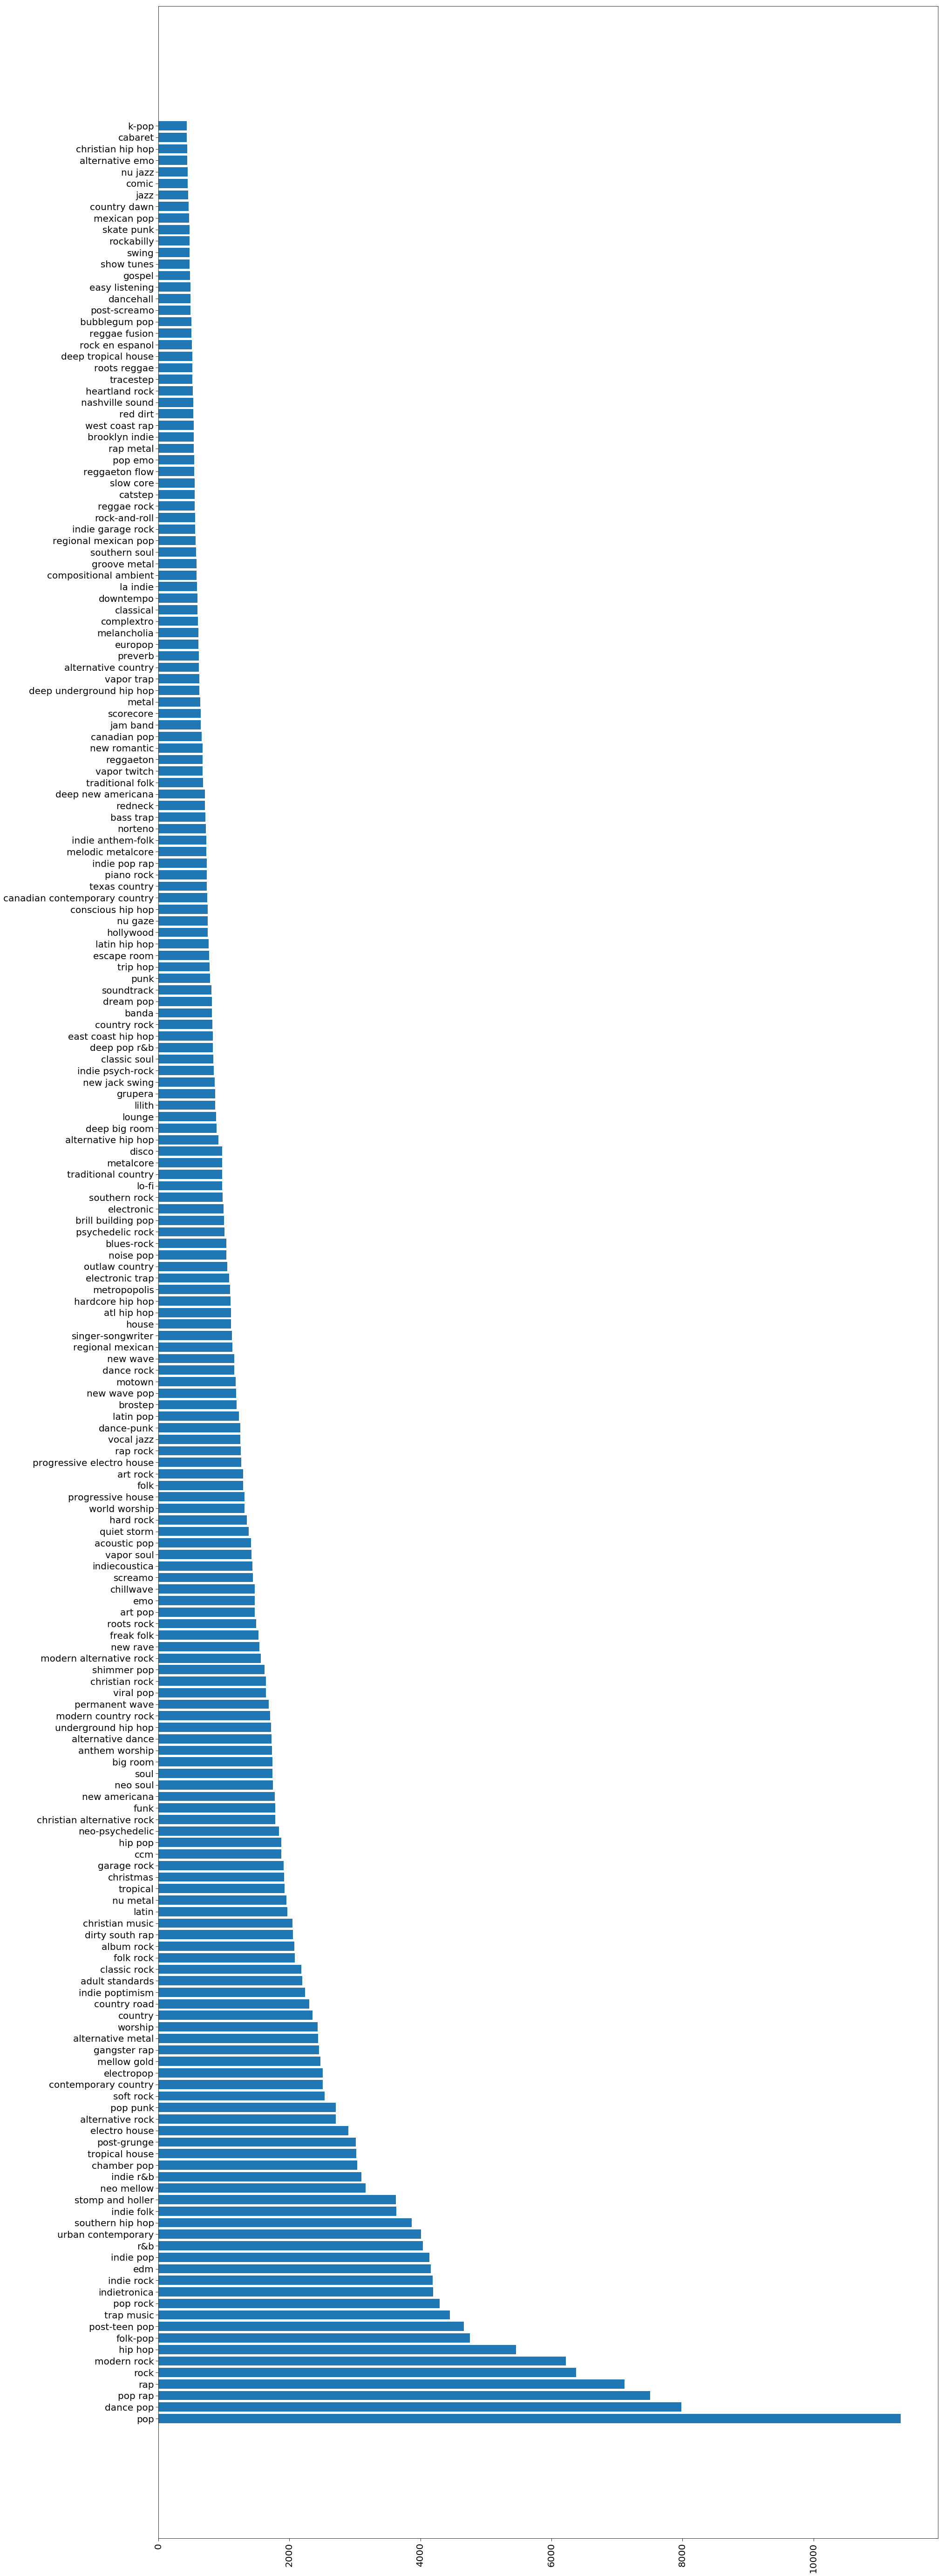

In [40]:
most = genre_counter.most_common(200)

genres = list(zip(*most))[0]
counts = list(zip(*most))[1]
x_pos = np.arange(len(genres)) 


# labels, values = zip(*genre_counter.items())
# indexes = np.arange(len(labels))
fig, ax=plt.subplots(1, 1, figsize=(30,100))
# # plt.
ax.barh(genres, counts)
plt.xticks(rotation=90)

ax.tick_params(labelsize=20, length=6)
# plt.xticks(indexes + width * 0.5, labels)
# ax.show()


Observations are in EDA write-up

## Split train and test data

In [31]:
train_data, test_data = train_test_split(clean_data, test_size=0.2, random_state=42)

In [32]:
train_data.shape, test_data.shape

((756, 27), (189, 27))

In [44]:
train_data.head()

collaborative description  duration_ms  modified_at              name  \
626         false         NaN       113182   1465948800            oldies   
307         false         NaN        95130   1445212800  BEST of the BEST   
662         false         NaN       108834   1413158400  Wedding Playlist   
394         false         NaN       181992   1505347200              work   
644         false         NaN        99303   1498780800              80's   

     num_albums  num_artists  num_edits  num_followers  num_tracks  \
626          20           13          6              1          29   
307           6            5          4              1           6   
662         108           85          9              1         118   
394          14           11          7              1          18   
644          92           76         16              1         124   

            ...          liveness   loudness      mode  speechiness  \
626         ...          0.095904  10.395262  0.309108     0.037497   
307         ...          0.079311   6.702235  0.306500     0.080765   
662         ...          0.095208   7.638851  0.376258     0.040694   
394         ...          0.146610  -0.752454  0.526765     0.056203   
644         ...          0.108970   4.641565  0.381629     0.043686   

     time_signature      tempo   valence    year  popularity  \
626             2.0  50.587736  0.210725  1976.0        67.0   
307             2.0  62.238285  0.195549  2007.0        44.0   
662             2.0  59.367200  0.267862  2014.0        55.0   
394             3.0  96.850685  0.386927  2014.0        51.0   
644             2.0  65.651773  0.308178  1976.0        51.0   

                  genre  
626       southern rock  
307  deep new americana  
662          neo mellow  
394         country rap  
644                rock  

[5 rows x 27 columns]

In [33]:
def make_row(track_id, row):
    features = feature_data[track_id]
    for feature in features:
        if feature not in str_feature:
            features[feature] = abs(features[feature] - row[feature])
    popularity = abs(popularity_data[track_id] - row['popularity'])
    features["popularity"] = int(popularity)
    return features

In [34]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
train_data_songs = pd.DataFrame([], columns=columns)
train_data_y = []
train_songs = {}
i = 1
total = train_data.shape[0]
for index, row in train_data.iterrows():
    progress_bar(i, total, 0)
    i += 1
    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index >  len(songs) *2/3:
            track_id = track
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id, row)
                train_data_songs = train_data_songs.append(features, ignore_index=True)
                train_data_y.append(1)
    other_keys = random.sample(song_keys, 30)

#     other_keys = get_new_songs(row["genre"], row["year"])
    for key in other_keys:
        if not key in tracks and key in feature_data:
            features = make_row(key, row)
            train_data_songs = train_data_songs.append(features, ignore_index=True)
            train_data_y.append(0)

print('hello')
train_data_songs = train_data_songs.set_index("id")

'|##############################| (756/756) with 0 failures'

hello


In [48]:
train_data_songs.head()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>acousticness</th>\n      <th>danceability</th>\n      <th>energy</th>\n      <th>instrumentalness</th>\n      <th>key</th>\n      <th>liveness</th>\n      <th>loudness</th>\n      <th>mode</th>\n      <th>speechiness</th>\n      <th>time_signature</th>\n      <th>tempo</th>\n      <th>valence</th>\n      <th>popularity</th>\n      <th>analysis_url</th>\n      <th>duration_ms</th>\n      <th>track_href</th>\n      <th>type</th>\n      <th>uri</th>\n    </tr>\n    <tr>\n      <th>id</th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>5QTxFnGygVM4jFQiBovmRo</th>\n     

In [49]:
# print(columns)
train_data_songs.dtypes
# train_data_songs[np.array(train_data_y) == 0][["popularity"]].describe()

acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
mode                float64
speechiness         float64
time_signature      float64
tempo               float64
valence             float64
popularity           object
analysis_url         object
duration_ms         float64
track_href           object
type                 object
uri                  object
dtype: object

In [50]:
train_data_songs["popularity"] = train_data_songs["popularity"].astype("float64")

In [51]:
train_data_songs[np.array(train_data_y) == 1][columns].describe()

acousticness  danceability       energy  instrumentalness          key  \
count   1412.000000   1412.000000  1412.000000       1412.000000  1412.000000   
mean       0.140293      0.187417     0.208500          0.085379     2.213259   
std        0.141182      0.123197     0.144052          0.134145     1.800579   
min        0.000011      0.000236     0.000261          0.000000     0.000000   
25%        0.049294      0.087334     0.093357          0.023142     0.904177   
50%        0.096463      0.177727     0.187830          0.042285     1.844949   
75%        0.168845      0.270287     0.294741          0.079946     2.949480   
max        0.735648      0.657733     0.671814          0.855334     8.352033   

          liveness     loudness         mode  speechiness  time_signature  \
count  1412.000000  1412.000000  1412.000000  1412.000000     1412.000000   
mean      0.077741     9.070581     0.310682     0.039512        1.310907   
std       0.100367     7.798967     0.201059     0.054602        0.811204   
min       0.000046     0.001130     0.000000     0.000011        0.000000   
25%       0.025006     3.389528     0.139931     0.011008        1.000000   
50%       0.053624     7.771309     0.298748     0.024691        1.000000   
75%       0.091437    12.411466     0.468511     0.045514        2.000000   
max       0.878370    66.956496     0.821881     0.575500        4.000000   

             tempo      valence   popularity  
count  1412.000000  1412.000000  1412.000000  
mean     38.363726     0.170084    15.764164  
std      25.068821     0.133488    13.066761  
min       0.044330     0.000266     0.000000  
25%      19.401526     0.069697     6.000000  
50%      36.317538     0.141921    12.000000  
75%      53.190012     0.233238    23.000000  
max     138.966608     0.718482    61.000000

In [52]:
train_data_songs[np.array(train_data_y) == 0][columns].describe()

acousticness  danceability        energy  instrumentalness  \
count  35982.000000  35982.000000  3.598200e+04      3.598200e+04   
mean       0.117205      0.176284  1.984539e-01      7.426379e-02   
std        0.121452      0.116710  1.364595e-01      1.240810e-01   
min        0.000009      0.000006  8.007486e-07      7.441935e-07   
25%        0.039552      0.081800  8.960556e-02      1.703931e-02   
50%        0.082706      0.163828  1.791417e-01      3.661927e-02   
75%        0.143566      0.252702  2.811393e-01      7.470558e-02   
max        1.300251      0.901205  9.369450e-01      1.059501e+00   

                key      liveness      loudness          mode   speechiness  \
count  35982.000000  3.598200e+04  35982.000000  35982.000000  35982.000000   
mean       1.804187  6.836738e-02      8.002174      0.236926      0.034639   
std        1.379875  6.711715e-02      8.392236      0.169724      0.034758   
min        0.000019  9.187470e-07      0.000227      0.000011      0.000004   
25%        0.789178  2.787624e-02      2.714785      0.106620      0.013158   
50%        1.567229  5.728685e-02      5.737675      0.204046      0.027354   
75%        2.470842  8.972504e-02     10.348791      0.330687      0.045572   
max       10.214411  8.800978e-01    220.416339      1.074542      0.922252   

       time_signature         tempo       valence    popularity  
count    35982.000000  35982.000000  3.598200e+04  35982.000000  
mean         1.197404     36.080445  1.560148e-01     17.071119  
std          0.861538     24.345239  1.159131e-01     11.759980  
min          0.000000      0.002623  5.028118e-07      0.000000  
25%          1.000000     16.952066  6.694844e-02      8.000000  
50%          1.000000     32.799611  1.385957e-01     15.000000  
75%          2.000000     51.237501  2.168769e-01     24.000000  
max          5.000000    185.151310  8.398772e-01     89.000000

[0.1402925426687546, 0.1874172755999735, 0.20849957502639957, 0.08537855185641931, 2.2132587099441703, 0.0777409163782562, 9.070580937425264, 0.3106818209407142, 0.03951177254916189, 1.3109065155807365, 0.17008359415817723, 15.76416430594901]
[0.11720504544681037, 0.17628403734522957, 0.19845389170589664, 0.07426379214079508, 1.8041867111483398, 0.06836737952686674, 8.002173965291298, 0.23692625860996416, 0.03463851942001097, 1.1974042576843977, 0.15601484517501787, 17.071118892779722]


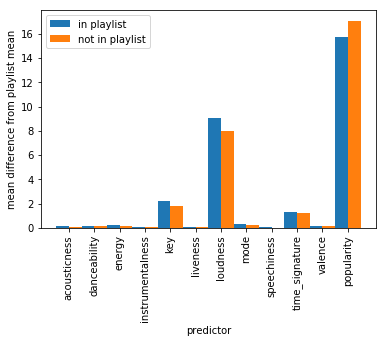

In [53]:
# we don't plot tempo b/c it's off the charts
pltcols=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
         "valence", "popularity"]
xs = np.arange((len(pltcols))) - 0.25
inplaylist = []
notinplaylist = []
for col in pltcols:
    if col != "tempo":
        d = train_data_songs[col]
        inplaylist.append(np.mean(d[np.array(train_data_y) == 1]))
        notinplaylist.append(np.mean(d[np.array(train_data_y) == 0]))
    
print(inplaylist)
print(notinplaylist)

    
plt.bar(xs, inplaylist, align='center', width=0.5, label="in playlist")
plt.bar(xs + 0.5, notinplaylist, align='center', width=0.5, label="not in playlist")
plt.xlabel("predictor")
plt.ylabel("mean difference from playlist mean")
plt.xticks([r for r in range(len(pltcols))], pltcols, rotation=90)
plt.legend()
# for col in train_data_songs.co

In [35]:
train_data_x = train_data_songs[columns]
train_data_x.head()

acousticness  danceability    energy  \
id                                                             
5HF5PRNJ8KGtbzNPPc93tG      0.066611      0.134649  0.283370   
2PfnAaQIMwHPvmda8MG5jm      0.317288      0.079423  0.249225   
5wU6jk9kxYzFGUpeE6T2Q5      0.106279      0.129353  0.109478   
25nzKGDiua1lE9Qo5V19GL      0.047540      0.114305  0.020860   
1eyzqe2QqGZUmfcPZtrIyt      0.135200      0.227262  0.059679   

                        instrumentalness       key  liveness   loudness  \
id                                                                        
5HF5PRNJ8KGtbzNPPc93tG          0.063394  1.906685  0.029623  12.946905   
2PfnAaQIMwHPvmda8MG5jm          0.003760  1.966643  0.076401  28.267300   
5wU6jk9kxYzFGUpeE6T2Q5          0.040173  0.534803  0.068640   0.750097   
25nzKGDiua1lE9Qo5V19GL          0.229958  0.092331  0.006994  13.729084   
1eyzqe2QqGZUmfcPZtrIyt          0.063945  2.634342  0.019184   6.277110   

                            mode  speechiness  time_signature      tempo  \
id                                                                         
5HF5PRNJ8KGtbzNPPc93tG  0.058856     0.011186             1.0  15.903150   
2PfnAaQIMwHPvmda8MG5jm  0.136684     0.023400             1.0   3.022934   
5wU6jk9kxYzFGUpeE6T2Q5  0.121826     0.006533             1.0  22.981591   
25nzKGDiua1lE9Qo5V19GL  0.054260     0.022137             1.0  12.657737   
1eyzqe2QqGZUmfcPZtrIyt  0.280379     0.007888             2.0  57.200498   

                         valence popularity  
id                                           
5HF5PRNJ8KGtbzNPPc93tG  0.307092          2  
2PfnAaQIMwHPvmda8MG5jm  0.166687          9  
5wU6jk9kxYzFGUpeE6T2Q5  0.108877          0  
25nzKGDiua1lE9Qo5V19GL  0.039327          3  
1eyzqe2QqGZUmfcPZtrIyt  0.068643          7

In [36]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

str_feature = set(["analysis_url", "id", "uri", "type", "track_id", "track_href"])
song_keys = feature_data.keys()
test_data_songs = pd.DataFrame([], columns=columns)
test_data_y = []
test_songs = {}
i = 1
total = test_data.shape[0]
for index, row in test_data.iterrows():
    progress_bar(i, total, 0)
    i += 1

    tracks = set([])
    for index, track in enumerate(row["tracks"]):
        if index > len(songs) *2/3:
            track_id = track
            tracks.add(track_id)
            if track_id in feature_data:
                features = make_row(track_id, row)
                test_data_songs = test_data_songs.append(features, ignore_index=True)
                test_data_y.append(1)
    other_keys = random.sample(song_keys, 30)
#     other_keys = get_new_songs(row["genre"], row["year"])
    songs = []
    for key in other_keys:
#         if not key in tracks:
#             if not key in feature_data:
        if not key in tracks and key in feature_data:
            features = make_row(key, row)
            test_data_songs = test_data_songs.append(features, ignore_index=True)
            test_data_y.append(0)
#         else:
#             new_songs.append(key)
            
test_data_songs = test_data_songs.set_index("id")
test_data_x = test_data_songs[columns]
train_data_x.head()

'|##############################| (189/189) with 0 failures'

acousticness  danceability    energy  \
id                                                             
5HF5PRNJ8KGtbzNPPc93tG      0.066611      0.134649  0.283370   
2PfnAaQIMwHPvmda8MG5jm      0.317288      0.079423  0.249225   
5wU6jk9kxYzFGUpeE6T2Q5      0.106279      0.129353  0.109478   
25nzKGDiua1lE9Qo5V19GL      0.047540      0.114305  0.020860   
1eyzqe2QqGZUmfcPZtrIyt      0.135200      0.227262  0.059679   

                        instrumentalness       key  liveness   loudness  \
id                                                                        
5HF5PRNJ8KGtbzNPPc93tG          0.063394  1.906685  0.029623  12.946905   
2PfnAaQIMwHPvmda8MG5jm          0.003760  1.966643  0.076401  28.267300   
5wU6jk9kxYzFGUpeE6T2Q5          0.040173  0.534803  0.068640   0.750097   
25nzKGDiua1lE9Qo5V19GL          0.229958  0.092331  0.006994  13.729084   
1eyzqe2QqGZUmfcPZtrIyt          0.063945  2.634342  0.019184   6.277110   

                            mode  speechiness  time_signature      tempo  \
id                                                                         
5HF5PRNJ8KGtbzNPPc93tG  0.058856     0.011186             1.0  15.903150   
2PfnAaQIMwHPvmda8MG5jm  0.136684     0.023400             1.0   3.022934   
5wU6jk9kxYzFGUpeE6T2Q5  0.121826     0.006533             1.0  22.981591   
25nzKGDiua1lE9Qo5V19GL  0.054260     0.022137             1.0  12.657737   
1eyzqe2QqGZUmfcPZtrIyt  0.280379     0.007888             2.0  57.200498   

                         valence popularity  
id                                           
5HF5PRNJ8KGtbzNPPc93tG  0.307092          2  
2PfnAaQIMwHPvmda8MG5jm  0.166687          9  
5wU6jk9kxYzFGUpeE6T2Q5  0.108877          0  
25nzKGDiua1lE9Qo5V19GL  0.039327          3  
1eyzqe2QqGZUmfcPZtrIyt  0.068643          7

## Building the Model

Model ideas: Find similar songs to all the songs in the playlist using Last.fm. Then do some sort of classification to determine whether we want to add them to our playlist using some parameters and then continue. Alternatively, pick the best songs, then classify their similar. **Use a neural network**

*This might be making the problem too easy, so maybe we select 1000 songs from the Genre or something and classify them*

https://www.last.fm/api

TODO: Pick parameters to optimize prediction

- Get other songs by the same artist
- Get songs same genre time period

- Split a playlist in 3/4 (1/4 for response)
- "Train" it to predict the response songs

- Most common genre and time period
- Search spotify and get 200 songs
- Run that through Neural Network

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
logreg = LogisticRegression(C=10000, solver='newton-cg', max_iter=100)
logreg.fit(train_data_x, train_data_y)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
coefs = zip(train_data_x.columns, logreg.coef_[0])
# print(list(coefs))
# print(logreg.coef_)
# print(train_data_x.columns)
# logreg.coef_

In [40]:
print(logreg.score(train_data_x, train_data_y))
print(logreg.score(test_data_x, test_data_y))

0.7006771772034506
0.7221530450532035


In [103]:
p = logreg.predict(test_data_x)
print(sum(p))
print(p)

2
[0 0 0 ... 0 0 0]


In [112]:
sum(train_data_y)
len(train_data_y)

37394

Can we improve it with cross-validation?

In [104]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

In [105]:
logregcv = LogisticRegressionCV(solver='saga', cv=5, max_iter=1000).fit(train_data_x, train_data_y)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


KeyboardInterrupt: 

In [106]:
logregcv.score(test_data_x, test_data_y)

NameError: name 'logregcv' is not defined

What about a Neural Network?

In [49]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GaussianNoise
from keras import regularizers
from sklearn.metrics import r2_score as r2


Using TensorFlow backend.


In [50]:
input_dim = len(columns)
n_hidden = 100

model = Sequential()
model.add(Dense(n_hidden, activation='relu', input_shape=(input_dim,)))
model.add(Dense(n_hidden, activation='sigmoid'))
model.add(Dense(n_hidden, activation='relu'))
model.add(Dense(n_hidden, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='sgd', loss='binary_crossentropy',  metrics=['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1400      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 31,801
Trainable params: 31,801
Non-trainable params: 0
_________________________________________________________________


In [51]:
epochs = 100
batch_size = 128

original_model = model.fit(train_data_x, train_data_y, epochs=epochs, validation_split = 0.5, verbose=0)

In [52]:
print(model.metrics_names)
train_score = model.evaluate(train_data_x, train_data_y, verbose=1)
print('Train loss:', train_score)
print('Train R2:', r2(train_data_y, model.predict(train_data_x)))

test_score = model.evaluate(test_data_x, test_data_y, verbose=1)
print('Test loss:', test_score)
print('Test R2:', r2(test_data_y, model.predict(test_data_x)))

['loss', 'binary_accuracy']
57149/57149 [==============================] - 1s 22us/step
Train loss: [0.584448044667288, 0.6917006421783581]
Train R2: 0.16527773167183135
17668/17668 [==============================] - 0s 21us/step
Test loss: [0.5637947876231553, 0.7138895177722436]
Test R2: 0.12582231704590918


In [72]:
print(model.predict(test_data_x))
print(model.predict(train_data_x))


[[0.04773448]
 [0.04772859]
 [0.0477286 ]
 ...
 [0.04791789]
 [0.04793758]
 [0.0479706 ]]
[[0.04792547]
 [0.04784435]
 [0.04793351]
 ...
 [0.04788957]
 [0.04780433]
 [0.04784943]]


# Let's Try It!
We'll give our model a country playlist and ask it to select songs

In [45]:
def getPlaylistSongs(id):
    url = base_url + '/playlists/' + id
    r =requests.get(url, headers=headers)
    data = r.json()
    return data['tracks']['items']

In [42]:
def getSongs(songs):
    url = base_url + '/tracks'
    i = 0
    payload = {'ids': ','.join(songs)}
    r =requests.get(url, headers=headers, params=payload)
    data = r.json()
    names = []
    for track in data['tracks']:
        names.append(track['name'])
    return names

In [59]:
columns=["acousticness", "danceability",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence", "popularity"]

def predictSongs(playlist_id, test_model):
    tracks = getPlaylistSongs(myplaylist)
    if tracks:
        features = {
            "acousticness": 0,
            "danceability": 0,
            "duration_ms" : 0,
            "energy" : 0,
            "instrumentalness" : 0,
            "key" : 0,
            "liveness" : 0,
            "loudness" : 0,
            "mode" : 0,
            "speechiness" : 0,
            "time_signature" : 0,
            "tempo" : 0,
            "valence" : 0,
        }
        albums = set({})
        years = set({})
        ids = set({})
        new_songs = pd.DataFrame([], columns=columns)
        songs = []
        seen = []
        for song in tracks:
            song_id = (song['track']['id'])
            ids.add(song_id)
            if song_id in feature_data:
                seen.append(song_id)
            else:
                songs.append(song_id)
                artist_id = song['track']['album']['artists'][0]['id']
                album_id = song['track']['album']['id']
                albums.add(album_id)
                artists.add(artist_id)
        try:
            song_features = get_features(songs)
            genres, genre_list = get_genres(list(artists))
            years, years_list = get_years(list(albums))
            popularity = get_popularity(songs)
            popularity_list = list(popularity)
            for song, feature, genre, year, pop in zip(songs, song_features, genre_list, years_list, popularity_list):
                feature_data[song] = feature
                genre_data[song] = genre
                year_data[song] = year
                popularity_data[song] = pop
            # add data from our seen songs
            for song in seen:
                song_features.append(feature_data[song])
    #             temp = ''
    #             for genre in genre_data[song]:
    #                 if len(genre) == 1:
    #                     print(genre)
                if type(genre_data[song]) == list:
                    for genre in genre_data[song]:
                        genres[genre] += 1
                else:
    #                 print(genre_data[song])
                    genres[genre_data[song]] += 1
                popularity.append(popularity_data[song])
                years[year_data[song]] += 1
#             print('here')
            # update popularity to be median value (not mean b/c outliers)
            popularity = np.median(popularity)
            features['popularity'] = popularity        

            # insert all information into features dict
            for song in song_features:
                for feature in all_features:
                    features[feature] += song[feature]
            # average necessary values and update data table
            for feature in feature_names:
                if feature in all_features:
                    features[feature] = features[feature] / len(tracks)
                    if feature == "time_signature":
                        features[feature] = int(features[feature] + 0.5)
                elif feature == "year":
                    features["year"] = int(years.most_common(1)[0][0])
                elif feature == "genre":
                    features["genre"] = genres.most_common(1)[0][0]
#                     print("genre", genres)
#             print(features)
#             id_set = set(ids)
#             random_songs = random.sample(song_keys, 30)

            random_songs = get_new_songs(features["genre"], features["year"])
            sample_songs = pd.DataFrame([], columns=columns)
            for key in random_songs:
                if not key in ids and key in feature_data:
                    stats = make_row(key, features)
                    sample_songs = sample_songs.append(stats, ignore_index=True)
            predictions = test_model.predict(sample_songs[columns])
            predicted_songs = []
            print(predictions)
            for i in range(len(predictions)):
                if predictions[i] >= 0.5:
                    predicted_songs.append(sample_songs.loc[i, "id"])
            if(len(predicted_songs) > 50):
                predicted_songs = predicted_songs[:50]
            elif(len(predicted_songs) == 0):
                return('No songs could be found')
#                 return(None)
            song_names = getSongs(predicted_songs)
            return song_names
        except Exception as ex:
            print('error', ex)
    else:
        print("Playlist cannot be found. Make sure it's not private!")

In [60]:
myplaylist = '4IRSXGb7jV2U8j06ToX1yz'
myplaylistfeatures = predictSongs(myplaylist, logreg)
print(myplaylistfeatures)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
['Make You Miss Me', 'Break Up In A Small Town', "I Don't Dance", 'I Like The Sound Of That', 'American Kids', 'Sunshine & Whiskey', "Nothin' Like You", 'Sangria', "Burnin' It Down", 'Anything Goes', 'Girl Crush', 'Ride (feat. Macy Maloy)', 'Drinking Class', 'Mind Reader']


In [61]:
myplaylist = '4IRSXGb7jV2U8j06ToX1yz'
myplaylistfeatures = predictSongs(myplaylist, model)
print(myplaylistfeatures)

[[0.7696002 ]
 [0.83521485]
 [0.8546719 ]
 [0.7532969 ]
 [0.7321439 ]
 [0.85754865]
 [0.76739866]
 [0.8695588 ]
 [0.8428141 ]
 [0.70789415]
 [0.8700114 ]
 [0.7500076 ]
 [0.87722224]
 [0.85153687]]
['Make You Miss Me', 'Break Up In A Small Town', "I Don't Dance", 'I Like The Sound Of That', 'American Kids', 'Sunshine & Whiskey', "Nothin' Like You", 'Sangria', "Burnin' It Down", 'Anything Goes', 'Girl Crush', 'Ride (feat. Macy Maloy)', 'Drinking Class', 'Mind Reader']


In [ ]:
len(myplaylistfeatures)

In [ ]:
['Ordinary Girl', 'Dust to Dust - Acoustic', 'Ghost', 'No One Is Alone', 'Beyond Oblivion', 'One More', 'Mokena', 'Accordion', 'Big Fat Bass', 'Knights', 'Just Around the Riverbend - From "Pocahontas" / Soundtrack Version', 'Only Son Of The Ladiesman', 'Do What You Have To Do', 'Midnight Train To Georgia', 'Pop Music', 'Pretty Girl']


In [ ]:
['Games People Play', 'Permanent Lover - 1990 Digital Remaster', 'In My Veins', 'Lullabies', 'This Is How We Do It', 'Sweet Nothing - Diplo + Grandtheft Remix', 'Smoke', 'Mirror Maru', 'Let Her Go - Live At Spotify Amsterdam', 'Peace Be Still', 'Sugar', 'Man With The Bag', 'Good Friend of Mine', 'Homegrown', 'My Dear', 'Please Come Home For Christmas', 'Sad Song (feat. Elena Coats)', 'Talking Dreams', 'Outsider']